# Bayesian Model Fitting in Python with emcee
## *Computational Research Day 2018 Workshop*


***
By AM Geller and AA Miller <br/>
April 10, 2018

Today we will focus on a seemingly simple problem : fitting a straight line to data.

Though we've all done this before, we've probably at some point oversimplified the analysis or at least not fully understood all the assumptions that went into our analysis. 

This workshop is inspired by the paper [Data Analysis Recipes: Fitting a Model to Data](https://arxiv.org/abs/1008.4686) by Hogg, Bovy, & Lang. If you haven't already read this paper, I ***highly*** recommend it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import minimize

import emcee
import corner

%matplotlib notebook

The first thing we need is the data.  Let's start with a prepared data set from that paper.  Later we can move to a real data set (maybe your own).

In this data set, you'll notice that each $\left(x,y\right)$ point has "one sigma" uncertainties, $\left(\sigma_x, \sigma_y\right)$ and also a correlation coefficient $\rho_{xy}$.  I found [this nice 1-page info sheet online](http://www.cs.utah.edu/~tch/CS4300/resources/refs/ErrorEllipses.pdf) if you want a further reference

The full uncertainty covariance matrix for each data point is given by:

$$S_i = \left[ {\begin{array}{cc}
        \sigma_{xi}^2 & \rho_{xyi}\sigma_{xi}\sigma_{yi} \\
        \rho_{xyi}\sigma_{xi}\sigma_{yi} & \sigma_{yi}^2  \\
        \end{array}
       }
       \right] 
       $$

In [2]:
obs_x = np.array([203, 58, 210, 202, 198, 158, 
                165, 201, 157, 131, 166, 160, 
                186, 125, 218, 146])
obs_y = np.array([495, 173, 479, 504, 510, 416, 
                393, 442, 317, 311, 400, 337, 
                423, 334, 533, 344])
sigma_x = np.array([5, 9, 4, 4, 11, 7, 
                    5, 5, 5, 6, 6, 5, 
                    9, 8, 6, 5])
sigma_y = np.array([21, 15, 27, 14, 30, 16, 
                    14, 25, 52, 16, 34, 31, 
                    42, 26, 16, 22])
rho_xy = np.array([-0.33, 0.67, -0.02, -0.05, -0.84, -0.69,
                    0.30, -0.46, -0.03, 0.50, 0.73, -0.52, 
                    0.90, 0.40, -0.78, -0.56])

Let's plot the data.

Text(0,0.5,'y')

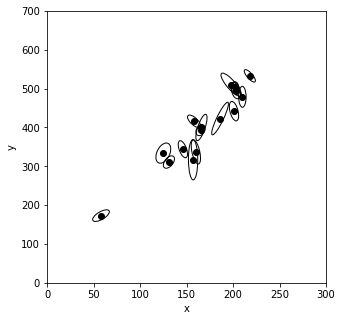

In [3]:
def plotData(ax, x, y, xerr, yerr, rhoxy, zorder = 10):
    
    #ax.errorbar(x, y, xerr = sigma_x, yerr = sigma_y, fmt = "o", capsize=3)
    ax.scatter(x, y, color = 'black', zorder = 10)
    for (xx, yy, sx, sy, rxy) in zip(x,y,sigma_x, sigma_y, rho_xy):
        #from here: https://www.unige.ch/sciences/astro/files/5413/8971/4090/2_Segransan_StatClassUnige.pdf
        #also here: http://www.cs.utah.edu/~tch/CS4300/resources/refs/ErrorEllipses.pdf
        #find better reference
        cov = np.array([[ sx**2, rxy*sx*sy],
                        [rxy*sx*sy, sy**2.]])
        w, v  = np.linalg.eig(cov)
        theta = np.arctan(2. * rxy * sx * sy / (sx**2. - sy**2.))/2.
        ax.add_artist(Ellipse((xx, yy), 2.*w[0]**0.5, 2.*w[1]**0.5, \
                              angle = np.rad2deg(theta),\
                              facecolor="none", edgecolor="black", zorder = zorder))
        
f, ax = plt.subplots(1, figsize = (5,5))
plotData(ax, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax.set_xlim(0,300)
ax.set_ylim(0,700)
ax.set_xlabel('x')
ax.set_ylabel('y')

Now, let's fit the line :

$y = mx + b$.  

How would you do this?

Probably the first attempt would be some kind of least squares optimization ... but ...

You'll quickly see that you can't easily account for the uncertainties on both $x$ and $y$ (simultaneously).  As a demonstration of ***WHAT NOT TO DO*** (but is sometimes attempted), here's an example of a "forward-reverse" fitting procedure, where you first fit by ignoring $\sigma_x$ then do the inverse and ignore $\sigma_y$.  

I repeat ***DO NOT DO THIS*** for a real publication.  This is only to illustrate a point.

The best-fit value for the ('forward') slope and intercept are: 2.2399 +/- 0.1345 and 34.0477 +/- 22.7656
The best-fit value for the ('reverse') slope and intercept are: 2.6352 +/- 0.2753 and -49.9429 +/- 44.4360


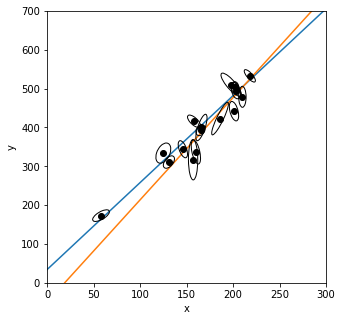

In [4]:
f, ax = plt.subplots(1, figsize = (5,5))
plotData(ax, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax.set_xlim(0,300)
ax.set_ylim(0,700)
ax.set_xlabel('x')
ax.set_ylabel('y')

#"abominable" forward–reverse fitting procedure
#DON'T DO THIS!
#polyfit with uncertainties on y ("forward")
p_xy, pcov = np.polyfit(obs_x, obs_y, 1, w = 1./sigma_y, cov = True)
err_xy = np.sqrt(np.diag(pcov))
p_xy_eval = np.poly1d(p_xy)
print("The best-fit value for the ('forward') slope and intercept are: {:.4f} +/- {:.4f} and {:.4f} +/- {:.4f}"\
      .format(p_xy[0], err_xy[0], p_xy[1], err_xy[1]))
ax.plot([0,300],p_xy_eval([0,300]),color='C0')

#polyfit with uncertainties on x ("reverse")
p_yx, pcov = np.polyfit(obs_y, obs_x, 1, w = 1./sigma_x, cov = True)
err_yx = np.sqrt(np.diag(pcov))
p_yx_eval = np.poly1d(p_yx)
inv = [1./p_yx[0], -p_yx[1]/p_yx[0]]
inv_err = [inv[0]**2.*err_yx[0],  (p_yx[0]**-2 * err_yx[1]**2. + (p_yx[1]/p_yx[0]**2.)**2. * err_yx[0]**2.)**0.5]
print("The best-fit value for the ('reverse') slope and intercept are: {:.4f} +/- {:.4f} and {:.4f} +/- {:.4f}"\
      .format(inv[0], inv_err[0], inv[1], inv_err[1]))
ax.plot(p_yx_eval([0.,700.]), [0.,700.],color='C1')

mFreq = p_xy[0]
bFreq = p_xy[1]


Again ***DO NOT DO THIS IN A PUBLICATION***. 

It should be fairly obvious why you don't want to do this.  For instance, 
- The results (at least for the intercept) are not in agreement, given the uncertainties on the parameters
- How would you combine these results to give some meaningful answer?
- Do you actually trust the uncertainties on these parameters?  Are the parameter uncertainties actually symmetric?
- Most importantly, neither method actually accounts for both uncertainties or their correlation coefficients ($\rho_{xy}$).

In [5]:
#a little bit more thorough and returns the same result as the "forward" fit
Y = obs_y.reshape(-1,1)
A = np.vstack((np.ones_like(obs_x), obs_x)).T
C = np.diag(sigma_y**2)

X = np.linalg.inv(A.transpose()@np.linalg.inv(C)@A) @ (A.transpose()@np.linalg.inv(C)@Y)

best_fit = np.poly1d(X[::-1,0])
print("The best-fit value for the slope and intercept are: {:.4f} and {:.4f}".format(X[1][0], X[0][0]))


#from emcee website
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, obs_y)))
print("The best-fit value for the slope and intercept are: {:.4f} and {:.4f}".format(m_ls, b_ls))


The best-fit value for the slope and intercept are: 2.2399 and 34.0477
The best-fit value for the slope and intercept are: 2.2399 and 34.0477


OK.  The naive first attempt is not appropriate for this problem.  That least squares fitting makes certain assumptions (e.g., that the errors on $x$ are negligible).  Let's relax those assumptions and frame the problem more generally.

First, some statistics... (Some of you may enjoy this, others may not.  It's OK if you don't fully understand all of this today.  We will get to the emcee fitter very soon.)



Most of us who use "Frequentist" statistical tools will recognize the "chi squared" value, which is the total squared error, after appropriately scaling by the uncertainties:

$$ \chi^2 = \Sigma_{i = 1}^{N} \frac{[y_i - f(x_i)]^2}{\sigma_{y_i}^2}$$

When we performed the least squares fitting above, that was equivalent to minimizing the $\chi^2$ value, given our model of $y = f(x) = mx + b$.

In "Bayesian" terminology, we could say the frequency distribution for $y_i$, givien an independend position $x_i$, an uncertainty $\sigma_{yi}$ and our model $f(x)$ is 

$$ p\left(y_i\, |\, x_i, \sigma_i, f(x_i) \right) = \chi^2 $$

Now, what we want to do is the maximize the probability of the observed data given the model, which is to say we want to maximize the *likelihood of the parameters*.  In Bayesian terminology, we would write the likelihood function $\mathscr{L}$ as the product of the conditional probabilities:

$$ \mathscr{L} = \prod_{i=1}^{N} p\left(y_i\, |\, x_i, \sigma_i, f(x_i) \right)$$

We often work in the logarithm of the likelihood, and for the case of $ p\left(y_i | x_i, \sigma_i, f(x_i) \right) = \chi^2 $, we get:

$$ \ln \mathscr{L} = K - \sum_{i=1}^{N} \frac{\left[y_i - f(x_i) \right]^2.}{2\sigma_{yi}^2} 
   = K - \frac{1}{2}\chi^2 $$
   
where $K$ is some constant.  Maximizing the likelihood is equivalent to minimizing the $\chi^2$.

Note: an important assumption in all of this is that the uncertainties, $\left(\sigma_x, \sigma_y\right)$, are Gaussian.  This is usually a reasonable assumption.

The Bayesian method is to use the frequency distribution along with prior knowledge of any model parameters, to define the "*posterior*" probability distribution:

$$ p\left(\theta\, |\, X, I\right) = \frac{p\left(X\, |\, \theta, I\right) p\left(\theta\, |\, I\right)}{p\left(X\, |\, I\right)} $$

In words, we want to know the (*posterior*) probability distribution for the parameters ($\theta$) given the data ($X$) and any prior knowledge ($I$), $p\left(\theta\, |\, X, I\right)$.  

$p\left(X\, |\, \theta, I\right)$ is the frequency distribution that we just defined.  

$p\left(\theta\, |\, I\right)$ is the "*prior*" probability distribution for the parameters, that contains all of our knowledge of what those parameters should be.  

The denominator can be thought of as a normalization constant that most people ignore (and we will also ignore it).

Ok.  That's very nice.  

But how do we actually use all this math??!!  

And, hey, you said this was a workshop about emcee!

In [6]:
def lnlike(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    ln_l = np.sum( np.log( 1./np.sqrt(2*np.pi *sigma_y**2.) * np.exp(-0.5*((y - model)/sigma_y)**2) ) )
    
    return ln_l.squeeze()

def lnprior(theta):
    m, b = theta
    if ( (0 < m < 10) and (-200 < b < 200) ):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lnp = lnprior(theta)
    lnl = lnlike(theta,  x, y, yerr)
    if (not np.isfinite(lnp) or not np.isfinite(lnl)):
        return -np.inf
    return lnp + lnl


Now, as a check, let's try to maximize this likelihood with scipy (well, actually we'll minimize -1 * likelihood)

In [7]:
def ilnlike(theta, x, y, yerr):
    return -lnlike(theta, x, y, yerr)

guess0 = np.array([2.*np.random.random() * mFreq, 2.*np.random.random() * bFreq])
scFit = minimize(ilnlike, guess0, args=(obs_x, obs_y, sigma_y))
print(scFit.message)
print("The initial guess for the slope and intercept are: {:.4f} and {:.4f}"\
      .format(guess0[0], guess0[1]))
print("The best-fit value for the slope and intercept are: {:.4f} and {:.4f}".format(scFit.x[0], scFit.x[1]))


Optimization terminated successfully.
The initial guess for the slope and intercept are: 3.2745 and 66.3690
The best-fit value for the slope and intercept are: 2.2399 and 34.0473


Now, let's use [emcee](http://dfm.io/emcee/current/), a pure-Python implementation of [Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler](https://msp.org/camcos/2010/5-1/p04.xhtml) written by [Dan Foreman-Mackey](http://dfm.io/).

We've already spent enough time on background, so I will let you read about MCMC (e.g., [here's the wikipedia entry](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)).  You may also want to read [journal article about emcee](https://arxiv.org/abs/1202.3665).

In short, we can use emcee to sample the posterior distribution that is defined by a Bayesian likelihood and priors (using MCMC).  emcee will use a number of "walkers" to explore this parameter space, each working their way toward the maximum of the likelihood function (while accounting for the priors).  The combination of the paths that each of these walkers take, i.e. their "chains", define the posterior distribution, and provide us with probability distributions for each of the model parameters.


In [8]:
nwalkers = 100
nfac = [1e-2, 1e-2]
ndim = len(guess0)
pos = [guess0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(obs_x, obs_y, sigma_y), threads = 6)

nsamples = 2000
foo = sampler.run_mcmc(pos, nsamples)


And now let's explore the output

In [9]:
# set a "burn-in" limit
nburn = 200
m_samples = np.array(sampler.chain[:,nburn:,0]).flatten()
b_samples = np.array(sampler.chain[:,nburn:,1]).flatten()

#print the results taking 1-sigma confidence intervals
samples = np.vstack([m_samples, b_samples]).T
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      m = {:.4f} +{:.4f} -{:.4f}\n \
      b = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(m_mcmc[0], m_mcmc[1], m_mcmc[2], b_mcmc[0], b_mcmc[1], b_mcmc[2]))

emcee results with 1-sigma uncertainties
       m = 2.2429 +0.1073 -0.1074
       b = 33.5800 +18.2640 -18.2938



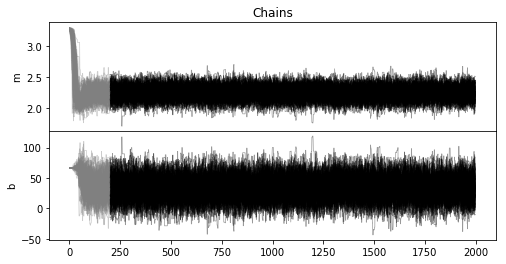

In [10]:
#some function to make plots (will re-use them later)
#to plot the chains
def plotChains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            
    return ax

paramsNames = ['m','b']

axC = plotChains(sampler, nburn, paramsNames)

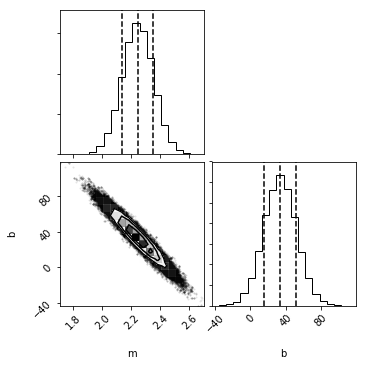

In [11]:
#corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84]):
    samples = sampler.chain[:, nburn:, :].reshape((-1, len(paramsNames)))
    f = corner.corner(samples, labels = paramsNames, quantiles = quantiles)

makeCorner(sampler, nburn, paramsNames)

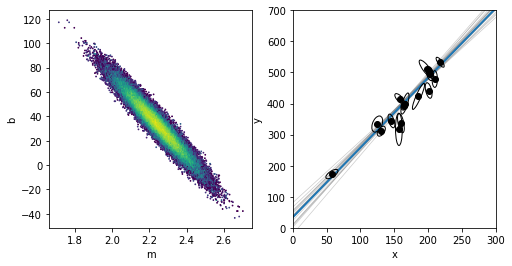

In [12]:
#Adam's plots
def prettyPlot(m_samples, b_samples, m, b, nburn, ndraw = 20):
    fig, ax = plt.subplots(1,2, figsize = (8,4))
    ax[0].set_xlabel("m")
    ax[0].set_ylabel("b")
    ax[1].set_xlabel("x")    
    ax[1].set_ylabel("y")
    ax[1].set_xlim(0,300)
    ax[1].set_ylim(0,700)
    
    ax[0].hexbin(m_samples, b_samples, gridsize = 250, bins = "log", mincnt = 1)

    plotData(ax[1], obs_x, obs_y, sigma_x, sigma_y, rho_xy)
    ax[1].plot([0,300], [b + 0*m, b + 300*m], lw = 2, zorder = 2)
    for rand_draw in np.random.randint(nburn, len(m_samples), ndraw):
        m_draw = m_samples[rand_draw]
        b_draw = b_samples[rand_draw]
        ax[1].plot([0,300], [b_draw + 0*m_draw, b_draw + 300*m_draw],
                 color = "0.5", alpha = 0.4, lw = 0.7, zorder = 1)

    return ax


axA = prettyPlot(m_samples, b_samples, m_mcmc[0], b_mcmc[0], nburn, ndraw = 20)

OK.  But... didn't we just get the same result as before? 

And, didn't you start this workshop talking about how we need to account for the uncertainties on $x$ as well?

To account for the uncertainties on the $x$ variable, we need do define a new likelihood function.  We've gone through a lot of statistics already, so, for the sake of time, we'll breeze through this.  Look at the Hogg paper for more details.

If we assume the uncertainties are Gaussian (as we are doing), we can write the probability for obtaining a measurement, 

$$ Z_i = \left[ {\begin{array}{c}
        x_i \\
        y_i \\
        \end{array}
       }
       \right] 
$$

when the "true value" (the value you would have this data point if it had been observed with negligible noise is:

$$ Z = \left[ {\begin{array}{c}
        x \\
        y \\
        \end{array}
       }
       \right] 
$$

as 

$$ p\left(x_i, y_i\, |\, S_i, x,y\right) = \frac{1}{2\pi \sqrt{\det(S_i)}} \exp\left(-\frac{1}{2}\left[Z_i - Z\right]^T S_i^{-1} \left[Z_i - Z\right]\right) $$

But how do we use this to fit a line?  (What should we use for Z?)  The "trick" is to project the 2D uncertainties onto the sub-space that is orthogonal to the line and to evaluate the projected displacements.  This will involve a change in variables from $(m, b)$ to $(\theta, b_\perp)$, as follows:

$$
\begin{align}
\theta &= \arctan m \\
b_\perp &= b \cos \theta \\
\hat{v} &= \left[ {\begin{array}{c}
        -\sin \theta \\
        \cos \theta \\
        \end{array}
       }
       \right] \\
\Delta_i &= \hat{v}\, Z_i - b_\perp \\
\Sigma_i^2 &= \hat{v}^T\, S_i\, \hat{v} \\
\ln \mathscr{L} &= K - \sum_{i=1}^{N} \frac{\Delta_i^2}{2\Sigma_i^2} \\
\end{align}
$$

In short, $\Delta_i$ is the orthogonal displacement of each data point $(x_i, y_i)$from the line, and $\Sigma^2$ is the orthogonal variance (by projecting the covariance matrix $S_i$, which we defined previously).

Whew!  Let's see that in action.

In [13]:
def lnlike(theta, x, y, xerr, yerr, rhoxy):
    th, bperp = theta
    lnl = 0.
    v = np.array([[-np.sin(th)], [np.cos(th)]])
    vT = v.transpose()
    for (xx, yy, sx, sy, rxy) in zip(x, y, xerr, yerr, rhoxy):
        S = np.array([[ sx**2, rxy*sx*sy],
                    [rxy*sx*sy, sy**2.]]) 
        Z = np.array([[xx],[yy]])
        Delta = vT @ Z - bperp
        Sigma2 = vT @ S @ v
        #lnl += (np.log( 1./(2.*np.pi * Sigma2)) - Delta**2. / (2. * Sigma2)) #this gives a slightly different result
        lnl -= Delta**2. / (2. * Sigma2) #this ignores the constant K but gives the same result as in the Hogg paper
        
    return lnl#.squeeze()

def lnprior(theta):
    th, bperp = theta
    if ( (0 < np.abs(th) < 2.*np.pi) and (-200 < bperp < 200)):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, xerr, yerr, rhoxy):
    lnp = lnprior(theta)
    lnl = lnlike(theta,  x, y, xerr, yerr, rhoxy)
    if (not np.isfinite(lnp) or not np.isfinite(lnl)):
        return -np.inf
    return lnp + lnl

def thFromM(m):
    return np.arctan(m)
def bpFromBth(b, th):
    return b * np.cos(th)
def mFromTh(th):
    return np.tan(th)
def bFromThBp(th, bp):
    return bp/np.cos(th)

In [14]:
nwalkers = 100
nfac = [1e-2, 1e-2]
ndim = len(guess0)
pos = [guess0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy), threads = 6)

nsamples = 2000
foo = sampler.run_mcmc(pos, nsamples)

And let's plot the results

In [15]:
# set a "burn-in" limit
nburn = 200
th_samples = np.array(sampler.chain[:,nburn:,0]).flatten()
bp_samples = np.array(sampler.chain[:,nburn:,1]).flatten()
m_samples = mFromTh(th_samples)
b_samples = bFromThBp(th_samples, bp_samples)

#print the results taking 1-sigma confidence intervals
samples = np.vstack([m_samples, b_samples]).T
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      m = {:.4f} +{:.4f} -{:.4f}\n \
      b = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(m_mcmc[0], m_mcmc[1], m_mcmc[2], b_mcmc[0], b_mcmc[1], b_mcmc[2]))

emcee results with 1-sigma uncertainties
       m = 2.1954 +0.1251 -0.1152
       b = 36.7901 +18.6050 -20.1454



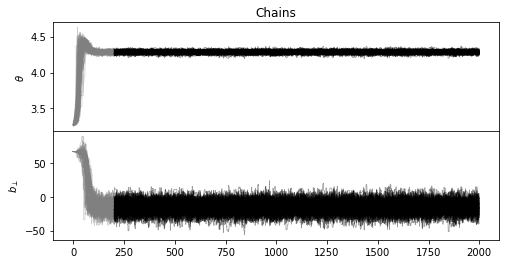

In [16]:
paramsNames = [r'$\theta$', r'$b_\perp$']

#chain plot
axC = plotChains(sampler, nburn, paramsNames)

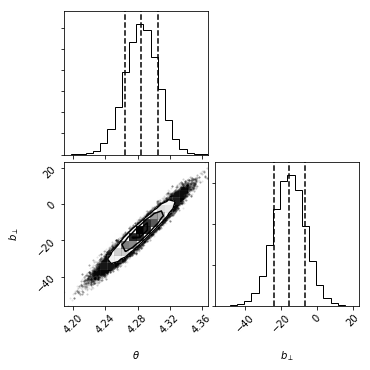

In [17]:
#corner plot
makeCorner(sampler, nburn, paramsNames)

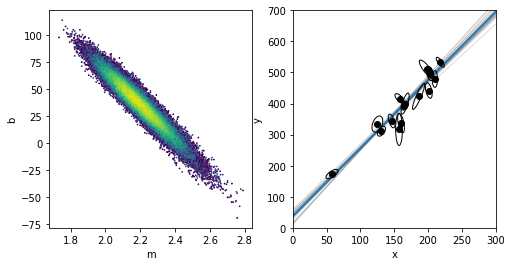

In [18]:
#Adam's plots
axA = prettyPlot(m_samples, b_samples, m_mcmc[0], b_mcmc[0], nburn, ndraw = 20)

So far we haven't really showcased the power of Bayesian model fitting.  One example of when you would really want to use a Baysian tool is when you have model parameters that you want to marginalize over.  The following example dives into this. 

We will append some outliers to our data (which you will often encounter in a real data set). 

Let's assume that the data is still best described by a line, and we think the best fit solution is what we found above (without the outliers).  Let's try to fit the line with scipy and using our previous likelihood function.  (You would get a similar result using emcee with the same likelihood.)

Optimization terminated successfully.
The best-fit value for the slope and intercept are: 1.3266 and 163.8364


Text(0,0.5,'y')

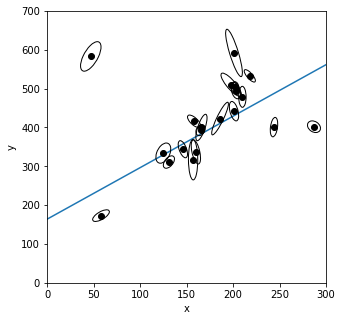

In [19]:
obs_x = np.append(obs_x, np.array([201, 244, 47, 287]))
obs_y = np.append(obs_y, np.array([592, 401, 583, 402]))
sigma_x = np.append(sigma_x, np.array([9, 4, 11, 7])) 
sigma_y = np.append(sigma_y, np.array([61, 25, 38, 15]))
rho_xy = np.append(rho_xy, np.array([-0.84, 0.31, 0.64, -0.27]))

def ilnlike(theta, x, y, xerr, yerr, rhoxy):
    return -lnlike(theta, x, y, xerr, yerr, rhoxy)

scFit = minimize(ilnlike, guess0, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy))
print(scFit.message)
mSci = mFromTh(scFit.x[0])
bSci = bFromThBp(scFit.x[0], scFit.x[1])
print("The best-fit value for the slope and intercept are: {:.4f} and {:.4f}".format(mSci, bSci))

f, ax = plt.subplots(1, figsize = (5,5))
plotData(ax, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax.plot( [0.,700.], mSci*np.array([0.,700.]) + bSci, color='C0')
ax.set_xlim(0,300)
ax.set_ylim(0,700)
ax.set_xlabel('x')
ax.set_ylabel('y')


Clearly this result is different from what we found before.  Given just this data set, without knowing which are "outliers", how could we verify this fit and deal with what we may think "by eye" are outliers?

We could try some type of sigma clipping algorithm.  This is very popular, but also rather subjective.  We don't want to introduce unnecesary biases into our fit.  So we want to ***avoid sigma clipping***.  

Instead we will develop a new likelihood function that will deal with these outliers.  Here is where the Bayesian approach really begins to shine...

# MAKE THIS WORK

In [ ]:
def lnlike(theta, x, y, xerr, yerr, rhoxy):
    th, bperp, pb, xb, vxb, yb, vyb  = theta
    lnl = 0.

    v = np.array([[-np.sin(th)], [np.cos(th)]])
    vT = v.transpose()

    #bad data
    #assuming rxy for the bad data is 1.
    #Sb = np.array([[ vxb, vxb**0.5*vyb**0.5],
    #        [vxb**0.5*vyb**0.5, vyb]]) 
    Zb = np.array([[xb],[yb]])
    DeltaBad = vT @ Zb - bperp
    
    #I think that I need Delta (which is basically mx + b) to be some combination of xb and yb
    #Delta is the orthogonal displacement of each point (x,y) from the line, but we just want displacement from xb, yb
    #then what would I do about Epsilon?, maybe it's the same?
    
    for (xx, yy, sx, sy, rxy) in zip(x, y, xerr, yerr, rhoxy):
        S = np.array([[ sx**2, rxy*sx*sy],
                    [rxy*sx*sy, sy**2.]]) 
        Sb = np.array([[ sx**2 + vxb, rxy*(sx*sy + vxb**0.5*vyb**0.5)],
                    [rxy*(sx*sy + vxb**0.5*vyb**0.5), sy**2. + vyb]]) 
        Z = np.array([[xx],[yy]])
        Delta = vT @ Z - bperp
        Sigma2 = vT @ S @ v
        
        Zb = np.array([[np.abs(xb - xx)],[np.abs(yb - yy)]])
        DeltaBad = vT @ Zb - bperp
        #DeltaBad = ((xx - xb)**2. + (yy - yb)**2.)**0.5
        SigmaBad2 = vT @ Sb @ v

#         lnlGood = -Delta**2. / (2. * Sigma2) #this ignores the constant K but gives the same result as in the Hogg paper
#         lnlBad = -DeltaBad**2. / (2. * SigmaBad2)

        lnlGood = 0.
        lnlBad = 0.
        if (Sigma2 > 0):
            lnlGood = np.log( 1./(2.*np.pi * Sigma2) * np.exp(-Delta**2. / (2. * Sigma2)))
        if (SigmaBad2 > 0):
            lnlBad = np.log( 1./(2.*np.pi * SigmaBad2) * np.exp(-DeltaBad**2. / (2. * SigmaBad2)))
            
        lnl += (1. - pb) * lnlGood + pb * lnlBad
        
    return lnl#.squeeze()

def lnprior(theta):
    th, bperp, pb, xb, vxb, yb, vyb,  = theta
    if ( (0 < np.abs(th) < 2.*np.pi) and (-200 < bperp < 200) and (0 < pb < 1.0) and \
        (0 < vxb < 1000.) and (-1000 < xb < 1000) and \
        (0 < vyb < 1000.) and (-1000 < yb < 1000) ):
        return 0.0
    return -np.inf


In [ ]:
nwalkers = 100
guess0 = np.array([thFromM(mFreq), bpFromBth(bFreq, thFromM(mFreq)), 0.2, 5., 1., 5., 1.])
nfac = np.full_like(guess0, 1e-2)
ndim = len(guess0)
pos = [guess0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy), threads=6)

nsamples = 5000
foo = sampler.run_mcmc(pos, nsamples)

In [ ]:
nburn = 200
th_samples = np.array(sampler.chain[:,nburn:,0]).flatten()
bp_samples = np.array(sampler.chain[:,nburn:,1]).flatten()
m_samples = mFromTh(th_samples)
b_samples = bFromThBp(th_samples, bp_samples)

#print the results taking 1-sigma confidence intervals
samples = np.vstack([m_samples, b_samples]).T
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      m = {:.4f} +{:.4f} -{:.4f}\n \
      b = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(m_mcmc[0], m_mcmc[1], m_mcmc[2], b_mcmc[0], b_mcmc[1], b_mcmc[2]))

paramsNames = [r'$\theta$', r'$b_\perp$', r'$p_b$', r'$x_b$', r'$v_{xb}$', r'$y_b$', r'$v_{yb}$']

#chain plot
axC = plotChains(sampler, nburn, paramsNames)

#corner plot
makeCorner(sampler, nburn, paramsNames)

#Adam's plots
axA = prettyPlot(m_samples, b_samples, m_mcmc[0], b_mcmc[0], nburn, ndraw = 20)


In [ ]:
import pandas as pd
from IPython.display import display

In [ ]:
#data from : http://adsabs.harvard.edu/abs/2009ApJ...698..198G
#Table 1
mSigma = pd.read_csv('apj303542t1_ascii.txt', quotechar='"', sep='\t')
print(mSigma.columns.values)
display(mSigma)

def fixSci(series):
    x = series.str.split(' ', expand = True)
    x2 = x[:][2].str.split('^', expand = True)
    return(x[:][0].astype("float") * 10.**x2[:][1].astype("float"))

def fixSig(series):
    x = series.str.split(' ', expand = True)
    return(x[:][0].astype("float"))
def fixSige(series):
    x = series.str.split(' ', expand = True)
    x2 = x[:][2].str.split('^', expand = True)
    return(x2[:][0].astype("float"))

obs_x = np.array(fixSci(mSigma['M_BH (M_sun)']))
obs_y = np.array(fixSig(mSigma['sigma_e (km s^-1)']))
sigma_y = np.array(fixSige(mSigma['sigma_e (km s^-1)']))
x_low = np.array(fixSci(mSigma['M_low (M_sun)']))
x_high = np.array(fixSci(mSigma['M_high (M_sun)']))
sigma_x_low = x_obs - x_low
sigma_x_high = x_high - x_obs
rho_xy = np.full_like(x_obs, 0.)

#Obviously not what we'd want to do
sigma_x = np.array([ (x1 + x2)/2. for (x1, x2) in zip(sigma_x_low, sigma_x_high)])

In [ ]:
f, ax = plt.subplots(1, figsize = (5,5))
print(len(obs_x), len(obs_y), len(sigma_x), len(sigma_y))
ax.errorbar(obs_x, obs_y, xerr = sigma_x, yerr = sigma_y, fmt = "o", capsize=3)
plotData(ax, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax.set_xscale("log")
ax.set_yscale("log")
